# Imports

In [86]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

# load original data format

In [2]:
with open('bsc-3m/traj_clustered.pkl', 'rb') as f:
    df = pickle.load(f)
with open('bsc-3m/traj_01_elab_new.pkl', 'rb') as f:
    frames = pickle.load(f)
    
df = df.join(frames['frames'])
df = df.loc[df['cluster'] != -1]

# load and prepare traffic light data

In [3]:
with open('bsc-3m/signal_lines_true.pickle', 'rb') as f:
    l_xy = pickle.load(f)

# map lights to clusters
# for n in range(24):
#     fig, ax = plt.subplots(figsize=(20,20))
#     im = Image.open("intersection2.png")
#     im = ImageOps.flip(im)
#     ax.set_xlim(0,1280)
#     ax.set_ylim(0,720)
#     ax.imshow(im, origin='lower')

#     mask = df['cluster'] == 0
#     s = df.loc[mask]
#     for _, row in s.iterrows():
#         ax.plot(row['xs'], row['ys'], c='b', alpha=0.05)
#     ax.plot(lights[n]['x'], lights[n]['y'], lw=20)
#     ax.set_title('number: ' + str(n))

In [4]:
light_dict = {
    0 : 7,
    1 : 6,
    2 : 5,
    3 : 9,
    4 : 8,
    5 : 6,
    6 : 10,
    7 : 6,
    8 : 4,
    9 : 4, 
    10 : 11,
    11 : 5
}

In [5]:
l_df = pd.read_csv('bsc-3m/signals_dense.csv')

# begin wrangling the data to use euclidean distance and more

In [6]:
def euc(x, y):
    v = np.vstack((x, y)).T
    distances = np.linalg.norm(v[:-1] - v[1:], axis=1)
    return distances

In [7]:
def get_mid(n):
    return np.array([sum(n['x'])/2, sum(n['y'])/2])

In [8]:
def d2l(x, y, mid):
    v = np.vstack((x, y)).T
    return np.linalg.norm(v - mid, axis=1)

In [9]:
d = {
    'x' : [],
    'y' : [],
    'euc' : [],
    'd_light' : [],
    'light_color' : [],
    'frames' : [],
    'class' : [],
    'cluster' : []
}

step_size = 1
for _, row in df.iterrows():
    rowx = np.array(row['xs'][::step_size])
    rowy = np.array(row['ys'][::step_size])
    frames = np.array(row['frames'][::step_size][:-1])
    l_mid = get_mid(l_xy[light_dict[row['cluster']]])
    
    d['x'].append(rowx[:-1])
    d['y'].append(rowy[:-1])
    d['light_color'].append(np.array([l_df.iloc[f][light_dict[row['cluster']]] for f in frames]))
    d['d_light'].append(d2l(rowx[:-1], rowy[:-1], l_mid))
    d['euc'].append(euc(rowx, rowy))
    d['frames'].append(frames)
    d['class'].append(row['class'])
    d['cluster'].append(row['cluster'])

pdf = pd.DataFrame(d)

In [10]:
with open('formatted.pkl', 'wb') as f:
    pickle.dump(pdf, f)

(array([290., 315., 191., 200., 769., 106., 123., 172., 386., 290., 971.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <BarContainer object of 11 artists>)

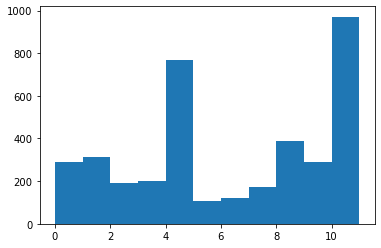

In [11]:
plt.hist(pdf['cluster'], bins=np.arange(12))

In [12]:
with open('formatted.pkl', 'rb') as f:
    df = pickle.load(f)

In [64]:
d = {
    'index' : [],
    'x' : [],
    'y' : [],
    'd_t-1' : [],
    'd_t-2' : [],
    'd_t-3' : [],
    'd_light' : [],
    'l0' : [],
    'l1' : [],
    'l2' : [],
    'l3' : [],
    'frame' : [],
    'cluster' : [],
    'class' : [],
    'target' : []
}

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.array([0,1,2,3]).reshape(-1,1))

for index, row in df.iterrows():
    for i in range(3, len(row['x'])):
        d['index'].append(index)
        d['x'].append(row['x'][i])
        d['y'].append(row['y'][i])
        d['d_t-1'].append(row['euc'][i-1])
        d['d_t-2'].append(row['euc'][i-2])
        d['d_t-3'].append(row['euc'][i-3])
        d['d_light'].append(row['d_light'][i])
        d['frame'].append(row['frames'][i])
        d['cluster'].append(row['cluster'])
        d['class'].append(row['class'])
        d['target'].append(row['euc'][i])
        
        # light color one hot encoding
        encoding = enc.transform([[row['light_color'][i]]]).toarray()
        for n in range(4):
            d['l'+str(n)].append(encoding[0,n])

In [65]:
nndf = pd.DataFrame(d)

<BarContainer object of 4 artists>

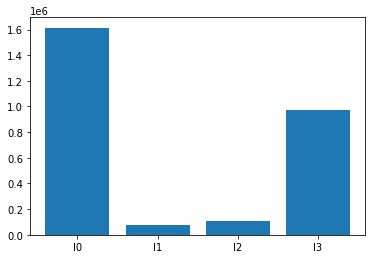

In [70]:
plt.bar(['l0', 'l1', 'l2', 'l3'], np.sum(nndf[['l0', 'l1', 'l2', 'l3']],axis=0))

# Train Validate Test split

In [92]:
cols = ['x', 'y', 'd_t-1', 'd_t-2', 'd_t-3', 'd_light', 'l0', 'l1', 'l2', 'l3', 'target']
this = nndf[cols]
df_train, df_val = train_test_split(this, test_size=0.2, random_state=1)
df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=1)

In [108]:
x_train, y_train = df_train[cols[:-1]].to_numpy(), df_train[cols[-1:]].to_numpy().reshape(-1)
x_val, y_val = df_val[cols[:-1]].to_numpy(), df_val[cols[-1:]].to_numpy().reshape(-1)
x_test, y_test = df_test[cols[:-1]].to_numpy(), df_test[cols[-1:]].to_numpy().reshape(-1)

# Train model

In [111]:
clf = MLPRegressor().fit(x_train, y_train)

In [112]:
clf.score(x_val, y_val)

0.999362940303329

(array([273391.,  20296.,  22488.,  20852.,  19515.,  17339.,  15374.,
         13820.,  12413.,  10937.,   9578.,   8164.,   7353.,   6763.,
          6195.,   5779.,   5472.,   5340.,   4939.,   4778.,   4550.,
          4370.,   4420.,   4182.,   4022.,   3847.,   3685.,   3485.,
          3236.,   3049.,   2829.,   2482.,   2191.,   1960.,   1589.,
          1334.,   1138.,    932.,    795.,    718.,    624.,    558.,
           499.,    456.,    407.,    406.,    407.,    337.,    298.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ,
        5.2, 5.4, 5.6, 5.8, 6. , 6.2, 6.4, 6.6, 6.8, 7. , 7.2, 7.4, 7.6,
        7.8, 8. , 8.2, 8.4, 8.6, 8.8, 9. , 9.2, 9.4, 9.6, 9.8]),
 <BarContainer object of 49 artists>)

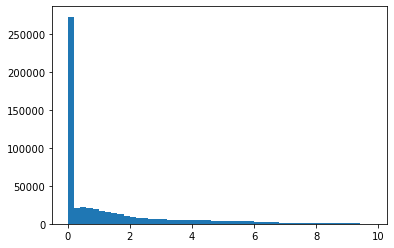

In [121]:
plt.hist(y_val, bins=np.arange(0,10,.2))

# Visualize

In [144]:
pdf

,x,y,euc,d_light,light_color,frames,class,cluster
0,"[6.1, 7.42, 8.76, 10.09, 11.43, 12.77, 14.11, ...","[445.6, 445.41, 445.23, 445.05, 444.87, 444.71...","[1.333604139165742, 1.3520355024924464, 1.3421...","[209.16228779408547, 207.837034188725, 206.492...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 4...",Car,4
1,"[1142.41, 1141.51, 1140.63, 1139.74, 1138.86, ...","[491.99, 491.93, 491.86, 491.78999999999996, 4...","[0.9019977827024653, 0.8827797007180166, 0.892...","[257.88695373651285, 256.99002786984863, 256.1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[220, 221, 222, 223, 224, 225, 226, 227, 228, ...",Car,11
2,"[4.44, 7.05, 9.69, 12.35, 15.03, 17.72, 20.43,...","[415.11, 413.77, 412.44, 411.12, 409.84, 408.6...","[2.9338882050957706, 2.956095397648722, 2.9695...","[193.85988286660884, 191.14102665434052, 188.3...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3375, 3376, 3377, 3378, 3379, 3380, 3381, 338...",Car,0
3,"[2.94, 4.0, 5.05, 6.09, 7.13, 8.16, 9.19, 10.2...","[450.73, 450.52, 450.31, 450.08, 449.82, 449.5...","[1.0806016842481856, 1.0707940978544805, 1.065...","[212.54101764119733, 211.47112910043313, 210.4...","[1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[4443, 4444, 4445, 4446, 4447, 4448, 4449, 445...",Car,4
4,"[1144.63, 1143.76, 1142.88, 1142.01, 1141.13, ...","[491.24, 491.26, 491.28999999999996, 491.32, 4...","[0.8702298546936924, 0.8805112151470816, 0.870...","[260.13557819169534, 259.2655043468766, 258.38...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4517, 4518, 4519, 4520, 4521, 4522, 4523, 452...",Car,11
...,...,...,...,...,...,...,...,...
3808,"[1172.28, 1171.68, 1171.07, 1170.47, 1169.87, ...","[477.43, 477.40999999999997, 477.39, 477.37, 4...","[0.6003332407920557, 0.6103277807868118, 0.600...","[288.6165523300192, 288.02047488139954, 287.41...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1095398, 1095399, 1095400, 1095401, 1095402, ...",Car,11
3809,"[1182.71, 1181.25, 1179.79, 1178.34, 1176.88, ...","[478.15999999999997, 478.25, 478.3300000000000...","[1.4627713423498943, 1.4621901381147777, 1.452...","[298.9501833691995, 297.48766937884625, 296.02...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1095656, 1095657, 1095658, 1095659, 1095660, ...",Car,11
3810,"[8.18, 12.67, 16.85, 20.84, 24.79, 28.83, 33.0...","[455.04, 454.84, 454.67, 454.55, 454.48, 454.4...","[4.494452135689068, 4.183455509504075, 3.99180...","[207.59669840521963, 203.10468938167534, 198.9...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1095759, 1095760, 1095761, 1095762, 1095763, ...",Car,4
3811,"[1180.44, 1178.96, 1177.49, 1176.02, 1174.55, ...","[477.39, 477.3, 477.22, 477.15, 477.0900000000...","[1.4827339613025827, 1.4721752613055545, 1.471...","[333.36001512477264, 331.90119508928956, 330.4...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1095777, 1095778, 1095779, 1095780, 1095781, ...",Car,10


In [151]:
row

x              [8.97, 11.67, 14.32, 16.93, 19.55, 22.21, 24.9...
y              [419.42, 418.54, 417.68, 416.87, 416.1, 415.37...
euc            [2.8397887245356808, 2.7860545579726224, 2.732...
d_light        [189.8030598807462, 187.019778992084, 184.2901...
light_color    [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...
frames         [56091, 56092, 56093, 56094, 56095, 56096, 560...
class                                                        Car
cluster                                                        0
Name: 107, dtype: object

In [152]:
def trajectory(row, d):
    pass

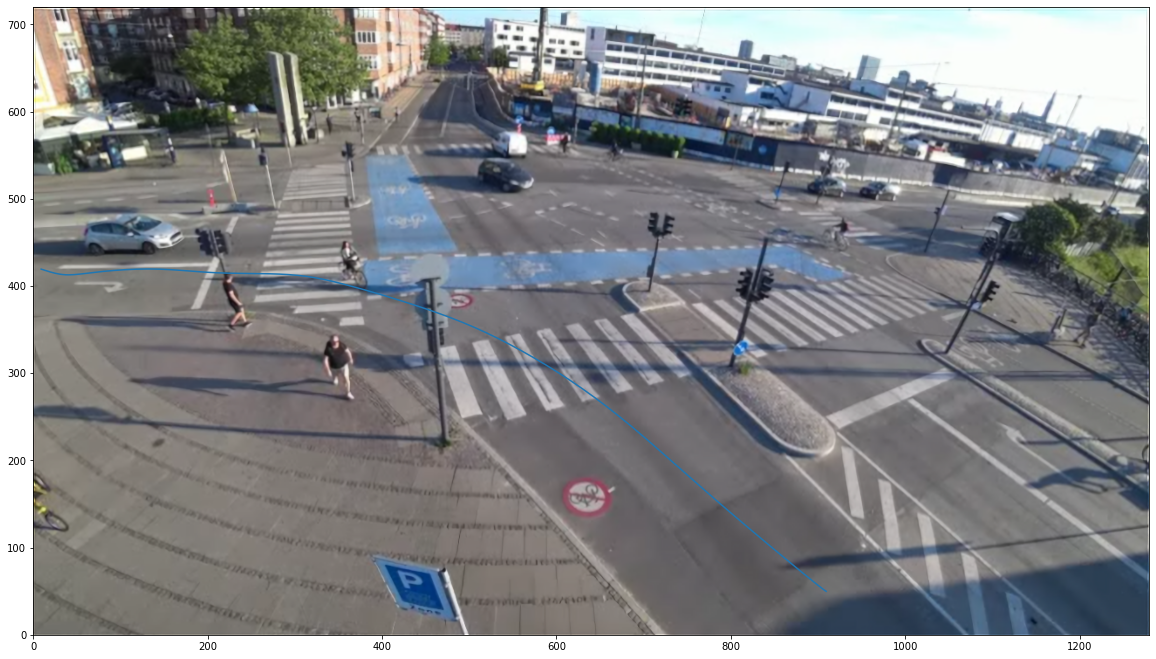

In [150]:
fig, ax = plt.subplots(figsize=(20,20))
im = Image.open("intersection2.png")
im = ImageOps.flip(im)
ax.set_xlim(0,1280)
ax.set_ylim(0,720)
ax.imshow(im, origin='lower')

row = pdf.iloc[107]
ax.plot(row['x'], row['y'])